### ASTROINFORMATICS
https://github.com/astromundus/ns_dec2018


#  Clustering (unsupervised classification) 

##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 6.  
 
- code taken and modified from astroML 

In [1]:
%matplotlib inline
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
from astroML.datasets import fetch_moving_objects
from astroML.plotting.tools import draw_ellipse
from astroML.clustering import HierarchicalClustering, get_graph_segments
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

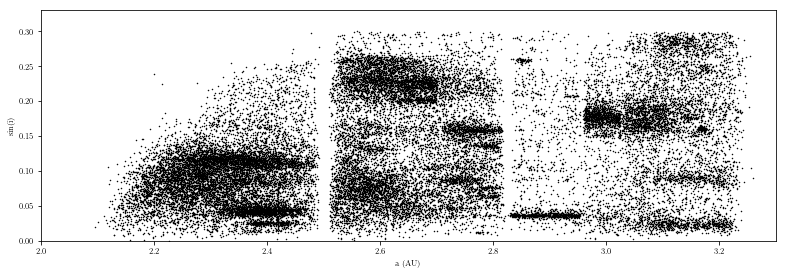

In [2]:
# Fetch data and extract the desired quantities
dataAll = fetch_moving_objects(Parker2008_cuts=True)
data = dataAll[1:]
a = data['aprime']
sini = data['sin_iprime']
acolor = data['mag_a']
izcolor = data['mag_i'] - data['mag_z']
X = np.vstack([a, sini]).T

#------------------------------------------------------------
# Plot 
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

In [3]:
#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 60)
def compute_GMM(N, covariance_type='full', max_iter=100):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GMM(n_components=N[i], max_iter=max_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]

print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  44


0 9 0.0397087073004
1 17 0.0376466305737
2 26 0.0364816128409
3 5 0.0356602802871
4 2 0.0340812889233
5 38 0.0327287982537
6 28 0.0319447136361
7 1 0.0298512092793
8 0 0.0296831041772
9 14 0.0291119796107
10 8 0.0290209543503
11 34 0.0286569038991
12 33 0.028385443007
13 19 0.0273649715992
14 43 0.0259618126629
15 3 0.0257266250046
16 18 0.025456178954
17 24 0.0247697405433
18 31 0.0246824381919
19 21 0.0244556972176
20 42 0.0230753616116
21 36 0.0224400234808
22 4 0.0214241847349
23 25 0.0212771053236
24 22 0.0202618271717
25 40 0.0195051314249
26 39 0.0187648957293
27 6 0.0186954022225
28 37 0.0181491996778
29 30 0.0178283780468
30 35 0.0176121999065
31 15 0.0170242686062
32 13 0.0168304167976
33 16 0.0162825170464
34 23 0.0162767698515
35 27 0.0160371230823
36 29 0.0154164094666
37 7 0.0141601271753
38 10 0.0139602245736
39 41 0.0139600495394
40 32 0.0130235178183
41 11 0.0124634457352
42 12 0.0107389827905
43 20 0.0034133478741


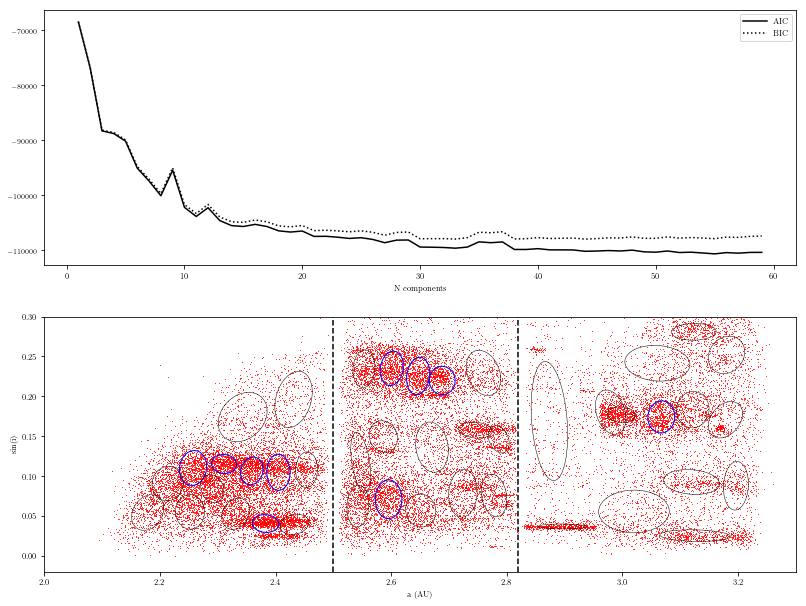

In [4]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

# plot AIC/BIC
ax = fig.add_subplot(211)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(212)

ax.scatter(a, sini, c='red', s=1, lw=0)

ind = np.argsort(gmm_best.weights_)[::-1]
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print(cnt, i, w)
    if (cnt<10):
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=1.0, ec='blue')
    else:
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=0.5, ec='k')
 
ax.plot([2.5, 2.5], [-0.02, 0.3], '--k')
ax.plot([2.82, 2.82], [-0.02, 0.3], '--k')

ax.set_xlim(2.0, 3.3)
ax.set_ylim(-0.02, 0.3)

ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

In [5]:
#------------------------------------------------------------
# Compute the Minimum Spanning Tree clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10, edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))
n_components = model.n_components_
labels = model.labels_
#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

 scale: 0.00319149


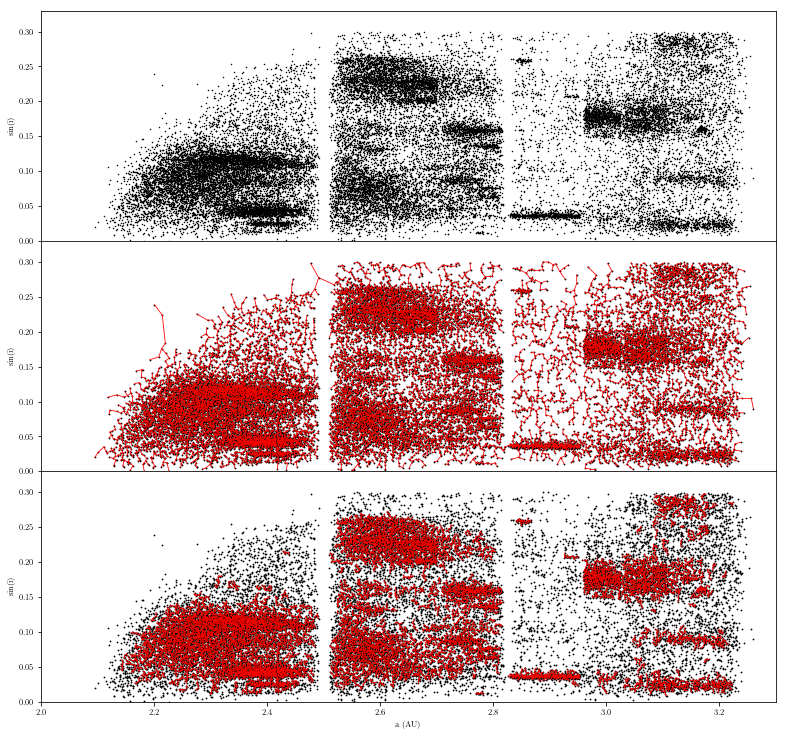

In [6]:
#------------------------------------------------------------
# Plot the results
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(312)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_x, T_y, c='red', lw=0.8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(313)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_trunc_x, T_trunc_y, c='red', lw=0.8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

![Parker et al. asteroid families](figures/MOC4_population_labels.jpg) 



#  Supervised Classification


##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.  
 
- code taken and modified from 
[astroML fig. 9.18](http://www.astroml.org/book_figures/chapter9/fig_star_quasar_ROC.html) 



## Classification of LINEAR variables

Let's apply a number of classification methods to 4-D data for periodic
variable stars from the SDSS and LINEAR surveys:

-- SDSS u-g and g-i colors, 

-- LINEAR variability period (logP) and variability amplitude (A).

For more details, see Homeworks 1 and 8 - this is the same data sample.  

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from astroML.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_geneva
from astroML.utils import split_samples
from astroML.classification import GMMBayes  # will become deprecated soon
#from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Fetch data and extract the desired quantities
data = fetch_LINEAR_geneva()
# this is a 7-dimensional dataset
attributes = [('gi', 'logP', 'ug', 'iK', 'JK', 'amp', 'skew')]
ug = data['ug']
gi = data['gi']
logP = data['logP']
amp = data['amp'] 
skew = data['skew'] 
labels = data['LCtype']
labels[labels == 6] = 3

In [3]:
Ndata = np.size(labels)
symbcolor = [''] * Ndata
symbcolor = np.where((labels == 1), 'red', symbcolor)
symbcolor = np.where((labels == 2), 'blue', symbcolor)
symbcolor = np.where((labels == 3), 'magenta', symbcolor)
symbcolor = np.where((labels == 4), 'green', symbcolor)
symbcolor = np.where((labels == 5), 'yellow', symbcolor)

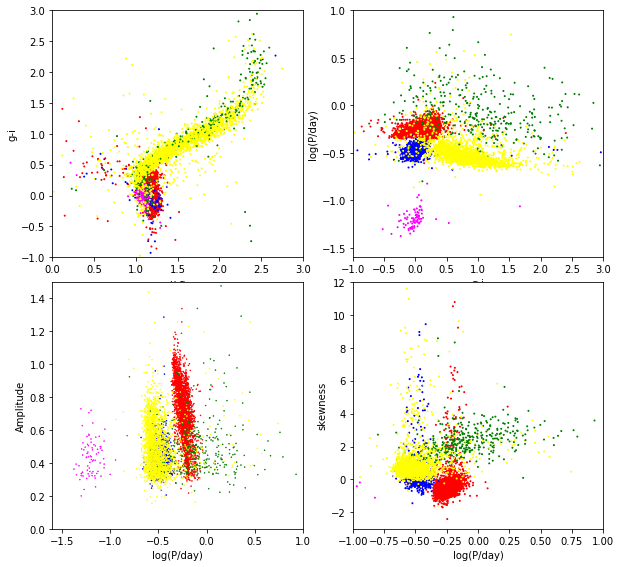

In [4]:
# Plot classes 
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(hspace=0.1, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(221)
xmin, xmax = (0.0, 3.0)
ymin, ymax = (-1.0, 3.0)
ax.scatter(ug, gi, s=1, lw=1.0, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('u-g')
ax.set_ylabel('g-i')

ax = fig.add_subplot(222)
xmin, xmax = (-1.0, 3.0)
ymin, ymax = (-1.6, 1.0)
ax.scatter(gi, logP, s=1, lw=1.0, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('g-i')
ax.set_ylabel('log(P/day)')

ax = fig.add_subplot(223)
xmin, xmax = (-1.6, 1.0)
ymin, ymax = (0.0, 1.5)
ax.scatter(logP, amp, s=1, lw=0.5, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('log(P/day)')
ax.set_ylabel('Amplitude')

ax = fig.add_subplot(224)
xmin, xmax = (-1.0, 1.0)
ymin, ymax = (-3, 12.0)
ax.scatter(logP, skew, s=1, lw=1.0, c=symbcolor)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('log(P/day)')
ax.set_ylabel('skewness')

plt.show()

In [5]:
Ndim = 4
X = np.empty((Ndata, Ndim), dtype=float)
X[:Ndata, 0] = ug
X[:Ndata, 1] = gi
if (Ndim > 2):
    X[:Ndata, 2] = logP
    X[:Ndata, 3] = amp

y = np.zeros(Ndata, dtype=int)
y[:Ndata] = labels

## RR Lyrae vs. other types: 
# set ab and c type RR Lyrae to 1, other to 0
y[y == 2] = 1
y[y != 1] = 0

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1], random_state=0) 

In [6]:
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print(classifier.__name__)
        model = classifier(**kwargs)
        # note that are using here the training subsample
        model.fit(X_train, y_train)
        # and here evaluating class using the testing subsample 
        #print(X_test)
        y_prob = model.predict_proba(X_test)
        #print('sss')
        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3)))

GaussianNB
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.

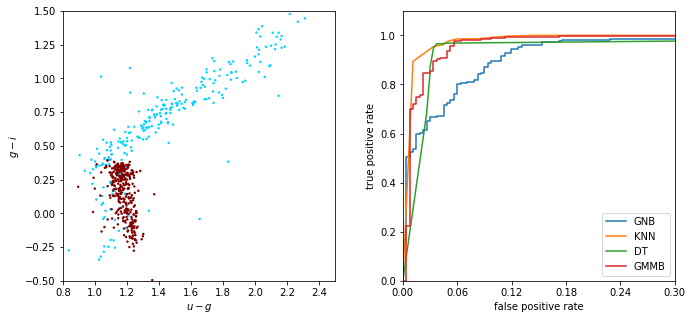

In [7]:
# Plot results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=6,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.jet)
#ax1.set_xlim(0.8, 1.5)
#ax1.set_ylim(-0.5, 0.9)
ax1.set_xlim(0.8, 2.5)
ax1.set_ylim(-0.5, 1.5)
im.set_clim(-0.5, 1)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - i$')

labels = dict(GaussianNB='GNB',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(122)
#print (names)
for name, y_prob in zip(names, probs):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    ax2.plot(fpr, tpr, label=labels[name])

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.3)
ax2.set_ylim(0.0, 1.1)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()